In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
import pandas as pd
%matplotlib inline
np.random.seed(1)

In [70]:
# Loading the dataset
df = pd.read_csv('adult.data', header = None)
X_train_orig = df.drop(df.columns[[14]], axis=1, inplace=False)
Y_train_orig = df[[14]]
#df
#print Y_train_orig
#print X_train_orig
X_train = pd.get_dummies(X_train_orig)
Y_train = pd.get_dummies(Y_train_orig) # get one hot encoding
#Y_train
#X_train
#X_train.shape[1]

In [73]:
df = pd.read_csv('adult.test', header = None)
X_test_orig = df.drop(df.columns[[14]], axis=1, inplace=False)
Y_test_orig = df[[14]]
X_test = pd.get_dummies(X_test_orig)
Y_test = pd.get_dummies(Y_test_orig) # get one hot encoding
Y_test
X_test
X_test.shape[1]

107

In [44]:
def create_placeholders(n_x, n_y):
    X = tf.placeholder(tf.float32, [n_x, None], name = "X")
    Y = tf.placeholder(tf.float32, [n_y, None], name = "Y")
    return X, Y

In [104]:
def initialize_parameters(num_features, num_layers):
    tf.set_random_seed(1)                   # so that your "random" numbers match ours
    num_neurons = []
    num_neurons.append(0)
    W = []
    W.append(0)
    b = []
    b.append(0)
    for i in range(1, num_layers + 1):
        if i == num_layers:
            num_neurons.append(2)
        else:
            num_neurons.append(10)
        if i == 1:
            arg2 = num_features
        else:
            arg2 = num_neurons[i - 1]
        W.append(tf.get_variable("W" + str(i), [num_neurons[i], arg2], 
                               initializer = tf.contrib.layers.xavier_initializer(seed = 1)))
        b.append(tf.get_variable("b" + str(i), [num_neurons[i] , 1], initializer = tf.zeros_initializer()))

    parameters = {}
    for i in range(1, num_layers + 1):
        parameters["W" + str(i)] = W[i]
        parameters["b" + str(i)] = b[i]
    return parameters

In [96]:
#tf.reset_default_graph() 
p = initialize_parameters(3,5)
print p

1
2
3
4
5
{'W1': <tf.Variable 'W1:0' shape=(5, 3) dtype=float32_ref>, 'b4': <tf.Variable 'b4:0' shape=(5, 1) dtype=float32_ref>, 'b5': <tf.Variable 'b5:0' shape=(2, 1) dtype=float32_ref>, 'W5': <tf.Variable 'W5:0' shape=(2, 5) dtype=float32_ref>, 'W4': <tf.Variable 'W4:0' shape=(5, 5) dtype=float32_ref>, 'W3': <tf.Variable 'W3:0' shape=(5, 5) dtype=float32_ref>, 'b1': <tf.Variable 'b1:0' shape=(5, 1) dtype=float32_ref>, 'b2': <tf.Variable 'b2:0' shape=(5, 1) dtype=float32_ref>, 'b3': <tf.Variable 'b3:0' shape=(5, 1) dtype=float32_ref>, 'W2': <tf.Variable 'W2:0' shape=(5, 5) dtype=float32_ref>}


In [99]:
def forward_propagation(X, parameters, num_layers):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W = []
    W.append(0)
    b = []
    b.append(0)
    Z = []
    Z.append(0)
    A = []
    A.append(X)
    for i in range(1, num_layers):
        W.append(parameters["W" + str(i)])
        b.append(parameters["b" + str(i)])
        Z.append(tf.add(tf.matmul(W[i], A[i - 1]), b[i]))
        A.append(tf.nn.relu(Z[i]))
                                        
    Z = tf.add(tf.matmul(parameters["W" + str(num_layers)], A[num_layers - 1]), parameters["b" + str(num_layers)])
    
    return Z

In [100]:
def compute_cost(Z, Y):
    """
    Computes the cost
    
    Arguments:
    Z -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    # to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
    logits = tf.transpose(Z)
    labels = tf.transpose(Y)
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = labels))
    
    return cost

In [103]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001, num_epochs = 1000, print_cost = True, num_layers = 5):
    """
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    
    Arguments:
    X_train -- training set, of shape (input size = 12288, number of training examples = 1080)
    Y_train -- test set, of shape (output size = 6, number of training examples = 1080)
    X_test -- training set, of shape (input size = 12288, number of training examples = 120)
    Y_test -- test set, of shape (output size = 6, number of test examples = 120)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep consistent results
    seed = 3                                          # to keep consistent results
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of shape (n_x, n_y)
    X, Y = create_placeholders(n_x, n_y)

    # Initialize parameters
    parameters = initialize_parameters(X_train.shape[0], num_layers)
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z = forward_propagation(X, parameters, num_layers)
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(Z, Y)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):
            _ , epoch_cost = sess.run([optimizer, cost], feed_dict={X: X_train, Y: Y_train})
                
            # Print the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        # print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
        return parameters

Cost after epoch 0: 932.746216
Cost after epoch 100: 102.746140
Cost after epoch 200: 0.583059
Cost after epoch 300: 0.559575
Cost after epoch 400: 0.549513
Cost after epoch 500: 0.536373
Cost after epoch 600: 0.530139
Cost after epoch 700: 0.529066
Cost after epoch 800: 0.528441
Cost after epoch 900: 0.527867
Cost after epoch 1000: 0.527318
Cost after epoch 1100: 0.526745
Cost after epoch 1200: 0.526153
Cost after epoch 1300: 0.525560
Cost after epoch 1400: 0.524933
Cost after epoch 1500: 0.525382
Cost after epoch 1600: 0.523619
Cost after epoch 1700: 0.522934
Cost after epoch 1800: 0.522233
Cost after epoch 1900: 0.521636
Cost after epoch 2000: 0.520805
Cost after epoch 2100: 0.520063
Cost after epoch 2200: 0.519319
Cost after epoch 2300: 0.518571
Cost after epoch 2400: 0.517811


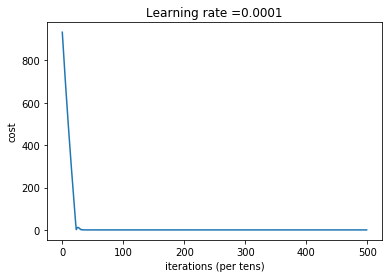

Parameters have been trained!
('Train Accuracy:', 0.79429376)


In [105]:
parameters = model(X_train.T, Y_train.T, X_test.T, Y_test.T, num_epochs = 2500)

In [38]:
parameters

{'W1': array([[ -3.62896711e-01,  -3.92981082e-01,  -3.50432396e-01,
          -1.86641216e-01,   1.25068605e-01,   6.57946467e-02,
           3.53324115e-01,  -5.77179790e-02,  -7.23782182e-02,
          -4.63488698e-02,  -1.77715600e-01,  -8.20072889e-02,
           3.64492953e-01,   2.00779259e-01,   6.94410801e-02,
           3.43843997e-01,   1.54298782e-01,  -8.22227001e-02,
          -1.74294695e-01,  -2.27560624e-01,   3.97456229e-01,
          -2.00143486e-01,   7.38465190e-02,   3.04749012e-01,
          -1.16930425e-01,  -7.38252997e-02,  -3.01831424e-01,
          -2.48914063e-02,  -2.01725364e-01,  -2.54542947e-01,
           1.93253338e-01],
        [ -1.03936195e-02,   8.30292702e-05,  -1.42860383e-01,
          -7.92998075e-03,   1.11947656e-02,  -2.43710563e-01,
           2.35907376e-01,   1.24957442e-01,  -4.52970862e-02,
          -3.00078809e-01,  -9.01323259e-02,   3.28528881e-01,
          -9.32728052e-02,  -1.49688274e-01,  -2.73389757e-01,
          -5.69962561